In [ ]:
# import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse


In [ ]:
# base setting for cifar100
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025)),
    #transforms.RandomErasing(value = (0.5074,0.4867,0.4411))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025)),
])

#download CIFAR100 dataset
trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

# we can use a larger batch size during test, because we do not save 
# intermediate variables for gradient computation, which leaves more memory
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat', 'deer',
#           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
for image,label in trainset:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

In [ ]:
len(trainset.classes)

In [ ]:
train_classes_items = dict()

for train_item in trainset:
    label = trainset.classes[train_item[1]]
    if label not in train_classes_items:
        train_classes_items[label] = 1
    else:
        train_classes_items[label] += 1

train_classes_items

In [ ]:
test_classes_items = dict()
for test_item in testset:
    label = testset.classes[test_item[1]]
    if label not in test_classes_items:
        test_classes_items[label] = 1
    else:
        test_classes_items[label] += 1

test_classes_items

See more examples at: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py



---



In [ ]:
# Training
def train(epoch, net, criterion, trainloader, scheduler):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
          print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

Test performance on the test set. Note the use of `torch.inference_mode()`

In [ ]:
def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total



In [ ]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')





In [ ]:
# defining resnet models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


In [ ]:
#------------------------------Main---------------------------------------------
config = {
    'lr': 0.01,
    'momentum': 0.9,
}
train_loss_ = []
train_acc_ = []
test_loss_ = []
test_acc_ = []
#ResNet 34
net = ResNet34().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

for epoch in range(1, 301):
    train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler)
    test_loss, test_acc = test(epoch, net, criterion, testloader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
      ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    
    train_loss_.append(train_loss)
    test_loss_.append(test_loss)
    train_acc_.append(train_acc)
    test_acc_.append(test_acc)


Epoch: 1
iteration :  50, loss : 4.4796, accuracy : 3.25
iteration : 100, loss : 4.2714, accuracy : 5.41
iteration : 150, loss : 4.1341, accuracy : 6.85
iteration : 200, loss : 4.0197, accuracy : 8.11
iteration : 250, loss : 3.9311, accuracy : 9.51
iteration : 300, loss : 3.8491, accuracy : 10.90
iteration : 350, loss : 3.7730, accuracy : 12.01
Epoch :   1, training loss : 3.7157, training accuracy : 12.88, test loss : 3.2159, test accuracy : 21.20

Epoch: 2
iteration :  50, loss : 3.0675, accuracy : 23.89
iteration : 100, loss : 3.0137, accuracy : 24.89
iteration : 150, loss : 2.9825, accuracy : 25.36
iteration : 200, loss : 2.9392, accuracy : 26.07
iteration : 250, loss : 2.9034, accuracy : 26.83
iteration : 300, loss : 2.8724, accuracy : 27.47
iteration : 350, loss : 2.8307, accuracy : 28.18
Epoch :   2, training loss : 2.8061, training accuracy : 28.74, test loss : 2.6538, test accuracy : 31.93

Epoch: 3
iteration :  50, loss : 2.3077, accuracy : 38.00
iteration : 100, loss : 2.31

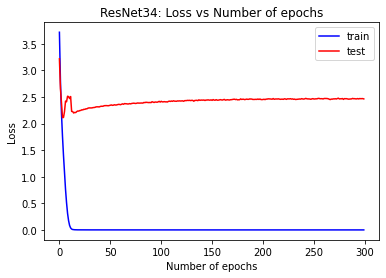

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_)), train_loss_, 'b')
plt.plot(range(len(test_loss_)), test_loss_, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("ResNet34: Loss vs Number of epochs")
plt.legend(['train', 'test'])
plt.show()

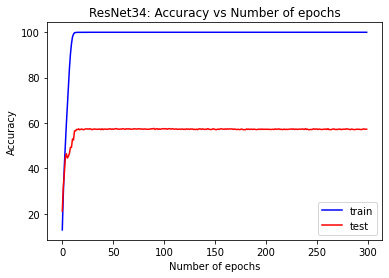

In [ ]:
plt.plot(range(len(train_acc_)), train_acc_, 'b')
plt.plot(range(len(test_acc_)), test_acc_, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("ResNet34: Accuracy vs Number of epochs")
plt.legend(['train', 'test'])
plt.show()

In [ ]:
# main body
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 5e-4
}


net = ResNet18().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

for epoch in range(1, 200):
    train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler)
    test_loss, test_acc = test(epoch, net, criterion, testloader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
      ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    


Epoch: 1
iteration :  50, loss : 1.9576, accuracy : 27.44
iteration : 100, loss : 1.8206, accuracy : 32.25
iteration : 150, loss : 1.7145, accuracy : 36.39
iteration : 200, loss : 1.6430, accuracy : 39.11
iteration : 250, loss : 1.5699, accuracy : 42.02
iteration : 300, loss : 1.5136, accuracy : 44.29
iteration : 350, loss : 1.4667, accuracy : 46.18
epoch :   1, training loss : 1.4241, training accuracy : 47.81, test loss : 1.1884, test accuracy : 58.42

Epoch: 2
iteration :  50, loss : 1.0251, accuracy : 63.84


KeyboardInterrupt: ignored

In [ ]:
5e-4

0.0005

In [ ]:
1e-2

0.01